# Etiquetado Automático de Frames usando CLIP

Este notebook usa CLIP (Contrastive Language-Image Pre-training) para etiquetar automáticamente los frames filtrados con categorías semánticas.

**Objetivo:**
- Etiquetar automáticamente frames por tipo de contenido visual (persona, logo, tabla, gráfico de velas, etc.)
- Usar CLIP para clasificación semántica basada en texto e imagen
- Guardar etiquetas para análisis posterior y entrenamiento de modelos

**Referencia:** [CLIP Image Retrieval System](https://github.com/AndresR2909/vision_aplicada/blob/main/taller_clase_3/image_retrieval_system.py)


## Configuración Inicial


In [6]:
#pip install transformers

In [1]:
import sys
import os
from pathlib import Path

# Configurar paths
project_root = Path("/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador")
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src"))

# Imports
import pandas as pd
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor
import warnings
warnings.filterwarnings('ignore')


/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuración de Categorías

Define las categorías visuales que quieres identificar. Puedes agregar más categorías según tus necesidades.


In [60]:
# Visual categories for classification (in English for better CLIP compatibility)
# CLIP was trained primarily on English data, so English descriptions work better
# You can add more categories according to your needs
CATEGORIES = [
    "a person speaking or presenting",
    "a logo or brand",
    "a table with data or numbers",
    "a candlestick chart or Japanese candlestick chart",
    "a line chart or line graph",
    "a bar chart or bar graph",
    "text or subtitles on screen",
    "a background image or full screen",
    "a diagram or infographic",
    "a screenshot of application or software",
    "other type of visual content"
]

CATEGORIES_2 = [
    "a person speaking or presenting",
    
    "a company logo, brand logo, or trademark image",
    
    "a data table, spreadsheet table, or numerical table with rows and columns",

    "a candlestick chart, Japanese candlestick chart, OHLC chart showing price movements",
    
    "a line chart, line graph showing data trends over time",
    
    "a bar chart, bar graph, column chart showing comparisons",
    
    "text overlay, subtitles, or captions displayed on screen",
    
    "a plain background, solid color background, or full screen background image",

    "a diagram, flowchart, or infographic showing information visually",
    
    "a computer screen, application interface, or software screenshot",
    
    "other type of visual content not matching the above categories"
]

# CATEGORIES_3: Prioriza "person" cuando hay una persona en el centro
# Las demás categorías especifican que no deben aplicarse si hay una persona visible
CATEGORIES_3 = [
    "a person speaking, presenting, or talking on camera, with a person visible in the center or foreground of the image",
    
    "a company logo, brand logo, or trademark image, without a person visible in the center or foreground",
    
    "a data table, spreadsheet table, or numerical table with rows and columns, without a person visible in the center or foreground",

    "a candlestick chart, Japanese candlestick chart, OHLC chart showing price movements, without a person visible in the center or foreground",
    
    "a line chart, line graph showing data trends over time, without a person visible in the center or foreground",
    
    "a bar chart, bar graph, column chart showing comparisons, without a person visible in the center or foreground",
    
    "only text overlay, subtitles, or captions displayed on screen, without a person visible in the center or foreground",
    
    "a plain background, solid color background, or full screen background image, without a person visible in the center or foreground",

    "a diagram, flowchart, or infographic showing information visually, without a person visible in the center or foreground",
    
    "a computer screen, application interface, or software screenshot, without a person visible in the center or foreground",
    
    "other type of visual content not matching the above categories, without a person visible in the center or foreground"
]

# Usar CATEGORIES_3 que prioriza "person" cuando hay una persona en el centro
CATEGORIES_TO_USE = CATEGORIES_3

# Short codes for categories (for use in columns)
CATEGORY_CODES = [
    "person",
    "logo",
    "table",
    "candlestick",
    "line_chart",
    "bar_chart",
    "text",
    "background",
    "diagram",
    "screenshot",
    "other"
]

print(f"📋 Categorías definidas: {len(CATEGORIES_TO_USE)}")
print(f"   Usando: CATEGORIES_3 (prioriza 'person' cuando hay persona en el centro)")
for i, (cat, code) in enumerate(zip(CATEGORIES_TO_USE, CATEGORY_CODES), 1):
    print(f"  {i}. [{code}] {cat}")


📋 Categorías definidas: 11
   Usando: CATEGORIES_3 (prioriza 'person' cuando hay persona en el centro)
  1. [person] a person speaking, presenting, or talking on camera, with a person visible in the center or foreground of the image
  2. [logo] a company logo, brand logo, or trademark image, without a person visible in the center or foreground
  3. [table] a data table, spreadsheet table, or numerical table with rows and columns, without a person visible in the center or foreground
  4. [candlestick] a candlestick chart, Japanese candlestick chart, OHLC chart showing price movements, without a person visible in the center or foreground
  5. [line_chart] a line chart, line graph showing data trends over time, without a person visible in the center or foreground
  6. [bar_chart] a bar chart, bar graph, column chart showing comparisons, without a person visible in the center or foreground
  7. [text] only text overlay, subtitles, or captions displayed on screen, without a person visible i

## Cargar Dataset de Frames Preprocesados


In [61]:
# Cargar dataset preprocesado
df_preprocessed_path = project_root / "src" / "notebooks" / "datasets" / "df_videos_frames_filtrados.csv"

if df_preprocessed_path.exists():
    df_videos = pd.read_csv(df_preprocessed_path)
    print(f"✅ Dataset cargado: {len(df_videos):,} videos")
    print(f"   Columnas: {df_videos.columns.tolist()}")
    
    # Expandir dataset: convertir frame_paths (lista) a una fila por frame
    print(f"\n📊 Expandindo dataset a nivel de frames...")
    
    import ast
    
    frames_list = []
    for idx, row in df_videos.iterrows():
        frame_paths = row['frame_paths']
        
        # Convertir string de lista a lista real
        try:
            if isinstance(frame_paths, str):
                frame_paths = ast.literal_eval(frame_paths)
        except:
            # Si falla, intentar split por comas
            frame_paths = frame_paths.split(',') if isinstance(frame_paths, str) else []
        
        # Crear una fila por cada frame
        for frame_path in frame_paths:
            if isinstance(frame_path, str):
                frame_path = frame_path.strip().strip("'\"[]")  # Limpiar comillas y brackets
            frames_list.append({
                'video_id': row['video_id'],
                'channel': row['channel'],
                'video_date': row['video_date'],
                'video_filename': row['video_filename'],
                'duration': row['duration'],
                'frame_path': frame_path,
                'n_frames_original': row.get('n_frames_original', row['n_frames']),
                'n_frames_filtrado': row.get('n_frames_filtrado', len(frame_paths) if isinstance(frame_paths, list) else 0),
                'reduction_percentage': row.get('reduction_percentage', 0)
            })
    
    df_frames = pd.DataFrame(frames_list)
    print(f"✅ Dataset expandido: {len(df_frames):,} frames")
    print(f"   Columnas: {df_frames.columns.tolist()}")
    print(f"\n📊 Primeras filas:")
    print(df_frames.head())
else:
    print(f"❌ No se encontró el archivo: {df_preprocessed_path}")
    print("   Ejecuta primero el notebook de preprocesamiento")


✅ Dataset cargado: 1,133 videos
   Columnas: ['video_id', 'channel', 'video_date', 'video_filename', 'duration', 'n_frames', 'frame_paths', 'n_frames_original', 'n_frames_filtrado', 'reduction_percentage']

📊 Expandindo dataset a nivel de frames...
✅ Dataset expandido: 377,494 frames
   Columnas: ['video_id', 'channel', 'video_date', 'video_filename', 'duration', 'frame_path', 'n_frames_original', 'n_frames_filtrado', 'reduction_percentage']

📊 Primeras filas:
      video_id                             channel  video_date  \
0  tKBpmMwwJaE  Bitcoin hoy ｜ Esteban Perez Trader    20220130   
1  tKBpmMwwJaE  Bitcoin hoy ｜ Esteban Perez Trader    20220130   
2  tKBpmMwwJaE  Bitcoin hoy ｜ Esteban Perez Trader    20220130   
3  tKBpmMwwJaE  Bitcoin hoy ｜ Esteban Perez Trader    20220130   
4  tKBpmMwwJaE  Bitcoin hoy ｜ Esteban Perez Trader    20220130   

             video_filename     duration  \
0  tKBpmMwwJaE_20220130.mp4  1019.333333   
1  tKBpmMwwJaE_20220130.mp4  1019.333333   
2  tKB

## Inicializar CLIP


In [62]:
# Configuración de CLIP
CLIP_MODEL_ID = 'openai/clip-vit-base-patch32'  # Modelo base de CLIP
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32  # Tamaño de lote para procesamiento

print(f"🔄 Cargando modelo CLIP: {CLIP_MODEL_ID}")
print(f"   Dispositivo: {DEVICE}")

# Cargar modelo y procesador CLIP
processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)
model = CLIPModel.from_pretrained(CLIP_MODEL_ID)
model.to(DEVICE)
model.eval()

print(f"✅ Modelo CLIP cargado exitosamente")
print(f"   Dimensión de embeddings: {model.config.projection_dim}")


🔄 Cargando modelo CLIP: openai/clip-vit-base-patch32
   Dispositivo: cpu
✅ Modelo CLIP cargado exitosamente
   Dimensión de embeddings: 512


## Extraer Embeddings de Texto (Categorías)


In [63]:
# Extraer embeddings de las categorías (texto)
print(f"📝 Extrayendo embeddings de {len(CATEGORIES_TO_USE)} categorías...")

category_embeddings = []

for i in tqdm(range(0, len(CATEGORIES_TO_USE), BATCH_SIZE)):
    batch_categories = CATEGORIES_TO_USE[i:i+BATCH_SIZE]
    
    # Procesar categorías como texto
    inputs = processor(
        text=batch_categories,
        images=None,
        return_tensors='pt',
        padding=True,
        truncation=True
    ).to(DEVICE)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        # Normalizar embeddings
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        category_embeddings.append(text_features.cpu().numpy())

# Concatenar todos los embeddings de categorías
category_embeddings = np.vstack(category_embeddings)

print(f"✅ Embeddings de categorías extraídos: {category_embeddings.shape}")


📝 Extrayendo embeddings de 11 categorías...


100%|██████████| 1/1 [00:00<00:00, 15.85it/s]

✅ Embeddings de categorías extraídos: (11, 512)


## Clasificar Frames con CLIP


In [64]:
# Función para clasificar una imagen
def classify_image(image_path, category_embeddings, model, processor, device):
    """
    Clasifica una imagen usando CLIP.
    
    Args:
        image_path: Ruta a la imagen
        category_embeddings: Embeddings de las categorías (texto)
        model: Modelo CLIP
        processor: Procesador CLIP
        device: Dispositivo (CPU/GPU)
    
    Returns:
        dict con 'category_idx', 'category_code', 'category_text', 'score'
    """
    try:
        # Cargar imagen
        image = Image.open(image_path).convert('RGB')
        
        # Procesar imagen
        inputs = processor(
            text=None,
            images=image,
            return_tensors='pt',
            padding=True
        )['pixel_values'].to(device)
        
        # Extraer embedding de imagen
        with torch.no_grad():
            image_features = model.get_image_features(inputs)
            # Normalizar
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            image_features = image_features.cpu().numpy()
        
        # Calcular similitud coseno con todas las categorías
        similarities = np.dot(image_features, category_embeddings.T)
        
        # Obtener categoría con mayor similitud
        best_category_idx = np.argmax(similarities)
        best_score = float(similarities[0, best_category_idx])
        
        return {
            'category_idx': int(best_category_idx),
            'category_code': CATEGORY_CODES[best_category_idx],
            'category_text': CATEGORIES_TO_USE[best_category_idx],
            'score': best_score,
            'all_scores': similarities[0].tolist()
        }
    except Exception as e:
        return {
            'category_idx': -1,
            'category_code': 'error',
            'category_text': f'Error: {str(e)}',
            'score': 0.0,
            'all_scores': [0.0] * len(CATEGORIES_TO_USE)
        }


In [65]:
# Procesar frames en lotes
print(f"🔍 Clasificando {len(df_frames):,} frames con CLIP...")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Dispositivo: {DEVICE}")

# Inicializar columnas de resultados
df_frames['clip_category_idx'] = -1
df_frames['clip_category_code'] = ''
df_frames['clip_category_text'] = ''
df_frames['clip_score'] = 0.0

# Procesar en lotes
results = []
errors = []

for idx, row in tqdm(df_frames.iterrows(), total=len(df_frames), desc="Clasificando"):
    frame_path = row['frame_path']
    
    # Verificar que el archivo existe
    if pd.isna(frame_path) or not os.path.exists(frame_path):
        errors.append((idx, frame_path, "Archivo no encontrado"))
        continue
    
    # Clasificar imagen
    result = classify_image(
        frame_path,
        category_embeddings,
        model,
        processor,
        DEVICE
    )
    
    # Guardar resultados
    df_frames.at[idx, 'clip_category_idx'] = result['category_idx']
    df_frames.at[idx, 'clip_category_code'] = result['category_code']
    df_frames.at[idx, 'clip_category_text'] = result['category_text']
    df_frames.at[idx, 'clip_score'] = result['score']
    
    results.append(result)

print(f"\n✅ Clasificación completada")
print(f"   Frames procesados: {len(results)}")
if errors:
    print(f"   Errores: {len(errors)}")


🔍 Clasificando 377,494 frames con CLIP...
   Batch size: 32
   Dispositivo: cpu


Clasificando: 100%|██████████| 377494/377494 [4:03:36<00:00, 25.83it/s]  


✅ Clasificación completada
   Frames procesados: 377494


## Análisis de Resultados


In [67]:
# Estadísticas de categorías
print("📊 DISTRIBUCIÓN DE CATEGORÍAS:")
print("=" * 80)

category_counts = df_frames['clip_category_code'].value_counts()
category_pct = df_frames['clip_category_code'].value_counts(normalize=True) * 100

for category in CATEGORY_CODES:
    count = category_counts.get(category, 0)
    pct = category_pct.get(category, 0)
    print(f"  {category:15s}: {count:6,} frames ({pct:5.2f}%)")

print(f"\n  {'TOTAL':15s}: {len(df_frames):6,} frames")

# Estadísticas de scores
print(f"\n📈 ESTADÍSTICAS DE SCORES:")
print("=" * 80)
print(f"  Media: {df_frames['clip_score'].mean():.4f}")
print(f"  Mediana: {df_frames['clip_score'].median():.4f}")
print(f"  Mínimo: {df_frames['clip_score'].min():.4f}")
print(f"  Máximo: {df_frames['clip_score'].max():.4f}")
print(f"  Desviación estándar: {df_frames['clip_score'].std():.4f}")


📊 DISTRIBUCIÓN DE CATEGORÍAS:
  person         : 44,408 frames (11.76%)
  logo           :  1,717 frames ( 0.45%)
  table          :  1,016 frames ( 0.27%)
  candlestick    : 270,376 frames (71.62%)
  line_chart     : 11,071 frames ( 2.93%)
  bar_chart      :  7,990 frames ( 2.12%)
  text           : 28,788 frames ( 7.63%)
  background     :  3,069 frames ( 0.81%)
  diagram        :  1,167 frames ( 0.31%)
  screenshot     :  5,084 frames ( 1.35%)
  other          :  2,808 frames ( 0.74%)

  TOTAL          : 377,494 frames

📈 ESTADÍSTICAS DE SCORES:
  Media: 0.2579
  Mediana: 0.2576
  Mínimo: 0.1639
  Máximo: 0.3480
  Desviación estándar: 0.0190


📊 Gráfico guardado en images/clip_category_distribution.png


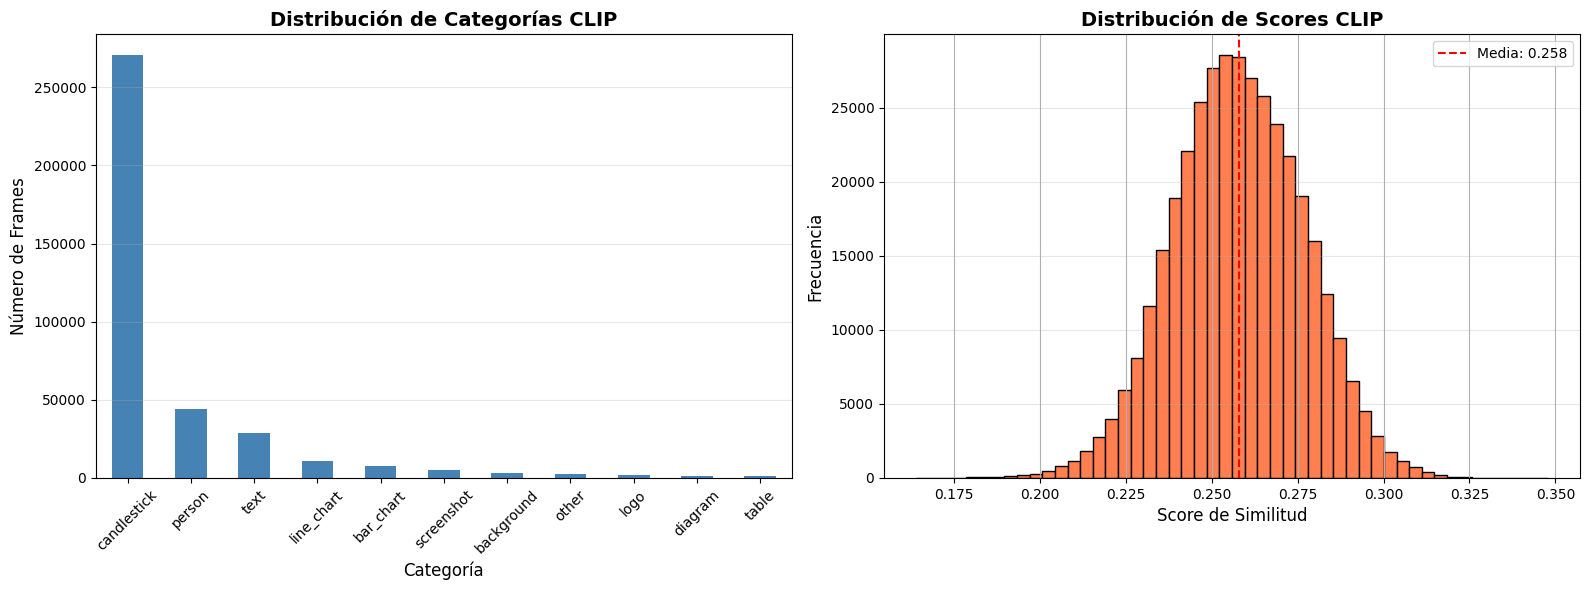

In [68]:
# Visualización de distribución de categorías
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras
ax1 = axes[0]
category_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Distribución de Categorías CLIP', fontsize=14, fontweight='bold')
ax1.set_xlabel('Categoría', fontsize=12)
ax1.set_ylabel('Número de Frames', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Distribución de scores
ax2 = axes[1]
df_frames['clip_score'].hist(bins=50, ax=ax2, color='coral', edgecolor='black')
ax2.set_title('Distribución de Scores CLIP', fontsize=14, fontweight='bold')
ax2.set_xlabel('Score de Similitud', fontsize=12)
ax2.set_ylabel('Frecuencia', fontsize=12)
ax2.axvline(df_frames['clip_score'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_frames["clip_score"].mean():.3f}')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/clip_category_distribution.png", dpi=300, bbox_inches='tight')
print(f"📊 Gráfico guardado en images/clip_category_distribution.png")
plt.show()


## Guardar Resultados


In [69]:
# Guardar dataset con etiquetas CLIP
os.makedirs("datasets", exist_ok=True)

output_path = project_root / "src" / "notebooks" / "datasets" / "df_frames_clip_labeled_v2.csv"
df_frames.to_csv(output_path, index=False)

print(f"💾 Dataset con etiquetas CLIP guardado:")
print(f"   Path: {output_path}")
print(f"   Shape: {df_frames.shape}")
print(f"   Columnas: {df_frames.columns.tolist()}")

# Guardar estadísticas
stats_path = project_root / "src" / "notebooks" / "datasets" / "clip_labeling_stats_v2.csv"
stats_df = pd.DataFrame({
    'category_code': category_counts.index,
    'count': category_counts.values,
    'percentage': category_pct.values
})
stats_df.to_csv(stats_path, index=False)
print(f"\n💾 Estadísticas guardadas en: {stats_path}")


💾 Dataset con etiquetas CLIP guardado:
   Path: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/datasets/df_frames_clip_labeled_v2.csv
   Shape: (377494, 13)
   Columnas: ['video_id', 'channel', 'video_date', 'video_filename', 'duration', 'frame_path', 'n_frames_original', 'n_frames_filtrado', 'reduction_percentage', 'clip_category_idx', 'clip_category_code', 'clip_category_text', 'clip_score']

💾 Estadísticas guardadas en: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/datasets/clip_labeling_stats_v2.csv


## Resumen


In [70]:
print("=" * 80)
print("RESUMEN DE ETIQUETADO CON CLIP")
print("=" * 80)

print(f"\n✅ Frames procesados: {len(df_frames):,}")
print(f"✅ Categorías definidas: {len(CATEGORIES_TO_USE)}")
print(f"✅ Usando: CATEGORIES_3 (prioriza 'person' cuando hay persona en el centro)")
print(f"✅ Modelo usado: {CLIP_MODEL_ID}")
print(f"✅ Dispositivo: {DEVICE}")

print(f"\n📊 Distribución de categorías:")
for category in CATEGORY_CODES[:5]:  # Mostrar top 5
    count = category_counts.get(category, 0)
    pct = category_pct.get(category, 0)
    print(f"   {category:15s}: {pct:5.2f}%")

print(f"\n💾 Archivos generados:")
print(f"   - datasets/df_frames_clip_labeled.csv")
print(f"   - datasets/clip_labeling_stats.csv")
print(f"   - images/clip_category_distribution.png")

print(f"\n💡 Próximos pasos:")
print(f"   - Revisar ejemplos visuales para validar calidad de etiquetas")
print(f"   - Ajustar categorías si es necesario")
print(f"   - Usar etiquetas para entrenar modelo de clasificación")
print(f"   - Combinar con clustering para análisis híbrido")


RESUMEN DE ETIQUETADO CON CLIP

✅ Frames procesados: 377,494
✅ Categorías definidas: 11
✅ Usando: CATEGORIES_3 (prioriza 'person' cuando hay persona en el centro)
✅ Modelo usado: openai/clip-vit-base-patch32
✅ Dispositivo: cpu

📊 Distribución de categorías:
   person         : 11.76%
   logo           :  0.45%
   table          :  0.27%
   candlestick    : 71.62%
   line_chart     :  2.93%

💾 Archivos generados:
   - datasets/df_frames_clip_labeled.csv
   - datasets/clip_labeling_stats.csv
   - images/clip_category_distribution.png

💡 Próximos pasos:
   - Revisar ejemplos visuales para validar calidad de etiquetas
   - Ajustar categorías si es necesario
   - Usar etiquetas para entrenar modelo de clasificación
   - Combinar con clustering para análisis híbrido


## Validación Visual de Etiquetas

Esta sección permite revisar visualmente los resultados del etiquetado para validar la calidad de las etiquetas asignadas por CLIP.


In [71]:
# Función para mostrar ejemplos de una categoría específica
def show_category_examples(category_code, n_examples=10, min_score=None, max_score=None):
    """
    Muestra ejemplos visuales de frames etiquetados con una categoría específica.
    
    Args:
        category_code: Código de la categoría a mostrar
        n_examples: Número de ejemplos a mostrar
        min_score: Score mínimo de confianza (opcional)
        max_score: Score máximo de confianza (opcional)
    """
    # Filtrar por categoría
    category_frames = df_frames[df_frames['clip_category_code'] == category_code].copy()
    
    if len(category_frames) == 0:
        print(f"❌ No se encontraron frames con categoría '{category_code}'")
        return
    
    # Filtrar por score si se especifica
    if min_score is not None:
        category_frames = category_frames[category_frames['clip_score'] >= min_score]
    if max_score is not None:
        category_frames = category_frames[category_frames['clip_score'] <= max_score]
    
    if len(category_frames) == 0:
        print(f"❌ No se encontraron frames con los filtros especificados")
        return
    
    # Ordenar por score (descendente) y tomar top N
    category_frames = category_frames.nlargest(n_examples, 'clip_score')
    
    print(f"🖼️  Ejemplos de categoría '{category_code}' ({len(category_frames)} de {len(df_frames[df_frames['clip_category_code'] == category_code])} totales):")
    print(f"   Score promedio: {category_frames['clip_score'].mean():.4f}")
    print(f"   Score mínimo: {category_frames['clip_score'].min():.4f}")
    print(f"   Score máximo: {category_frames['clip_score'].max():.4f}\n")
    
    # Calcular grid de imágenes
    cols = 5
    rows = (len(category_frames) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (idx, row) in enumerate(category_frames.iterrows()):
        row_idx = i // cols
        col_idx = i % cols
        
        try:
            image = Image.open(row['frame_path'])
            axes[row_idx, col_idx].imshow(image)
            title = f"{category_code}\nScore: {row['clip_score']:.3f}\n{row['channel'][:20]}"
            axes[row_idx, col_idx].set_title(title, fontsize=9)
            axes[row_idx, col_idx].axis('off')
        except Exception as e:
            axes[row_idx, col_idx].text(0.5, 0.5, f'Error\n{str(e)[:30]}', 
                                        ha='center', va='center', fontsize=8)
            axes[row_idx, col_idx].axis('off')
    
    # Ocultar ejes vacíos
    for i in range(len(category_frames), rows * cols):
        row_idx = i // cols
        col_idx = i % cols
        axes[row_idx, col_idx].axis('off')
    
    plt.suptitle(f'Top {len(category_frames)} Ejemplos - Categoría: {category_code}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return category_frames



### Revisar Ejemplos por Categoría

Ejecuta las siguientes celdas para revisar ejemplos visuales de cada categoría. Esto te ayudará a validar la calidad del etiquetado.


In [72]:
CATEGORY_CODES[0]

'person'

🖼️  Ejemplos de categoría 'person' (15 de 44408 totales):
   Score promedio: 0.3016
   Score mínimo: 0.2975
   Score máximo: 0.3088



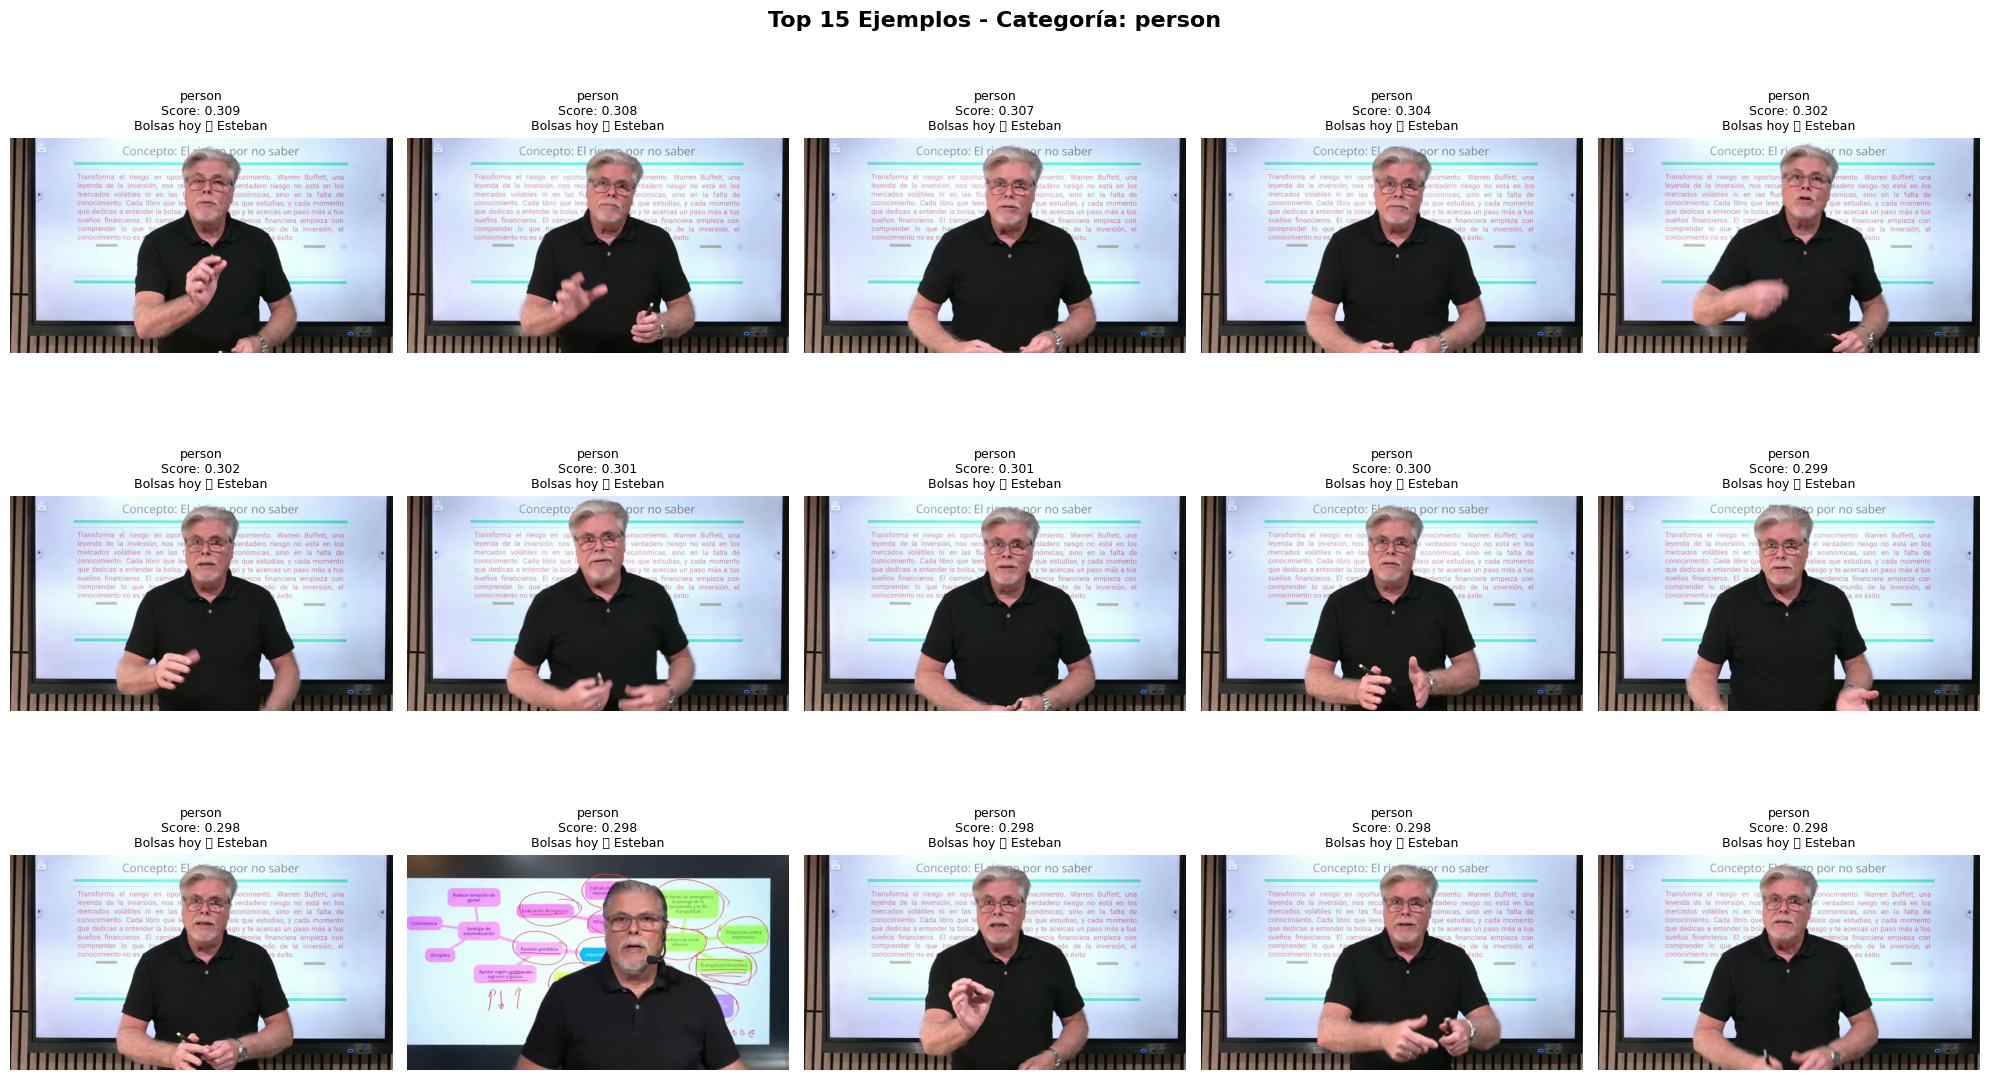

In [73]:
# Configuración para revisión
CATEGORY_TO_REVIEW = CATEGORY_CODES[0] #"candlestick"  # Cambia esto para revisar otra categoría
N_EXAMPLES = 15  # Número de ejemplos a mostrar
MIN_SCORE = 0.25  # Score mínimo (None = sin filtro, ej: 0.25)
MAX_SCORE = None  # Score máximo (None = sin filtro)

# Mostrar ejemplos
examples = show_category_examples(
    category_code=CATEGORY_TO_REVIEW,
    n_examples=N_EXAMPLES,
    min_score=MIN_SCORE,
    max_score=MAX_SCORE
)


🖼️  Ejemplos de categoría 'bar_chart' (15 de 7990 totales):
   Score promedio: 0.3000
   Score mínimo: 0.2965
   Score máximo: 0.3029



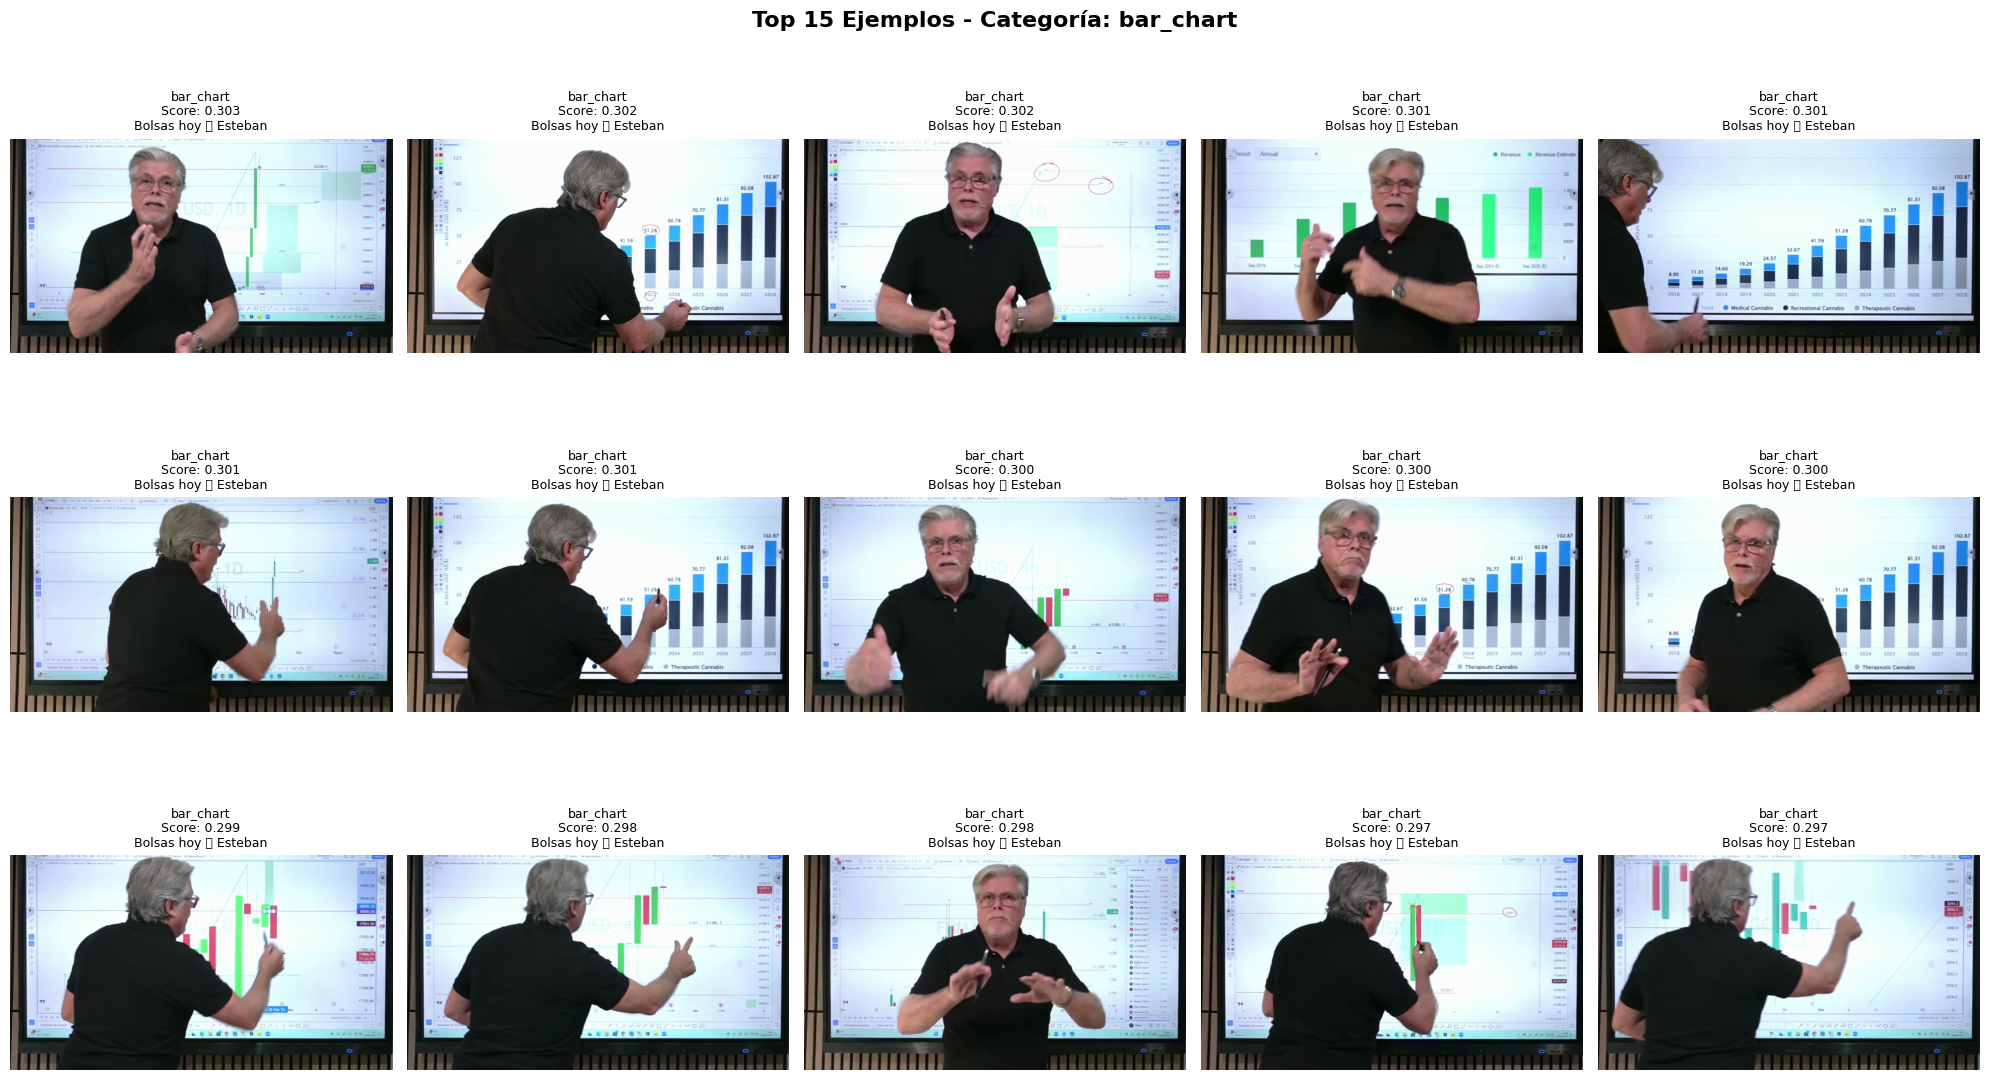

In [82]:
# Configuración para revisión
CATEGORY_TO_REVIEW = CATEGORY_CODES[5]  # Cambia esto para revisar otra categoría
N_EXAMPLES = 15  # Número de ejemplos a mostrar
MIN_SCORE = 0.21 # Score mínimo (None = sin filtro, ej: 0.25)
MAX_SCORE = None  # Score máximo (None = sin filtro)

# Mostrar ejemplos
examples = show_category_examples(
    category_code=CATEGORY_TO_REVIEW,
    n_examples=N_EXAMPLES,
    min_score=MIN_SCORE,
    max_score=MAX_SCORE
)

📊 Vista general de todas las categorías:
📊 Vista general guardada en images/clip_category_examples_overview.png


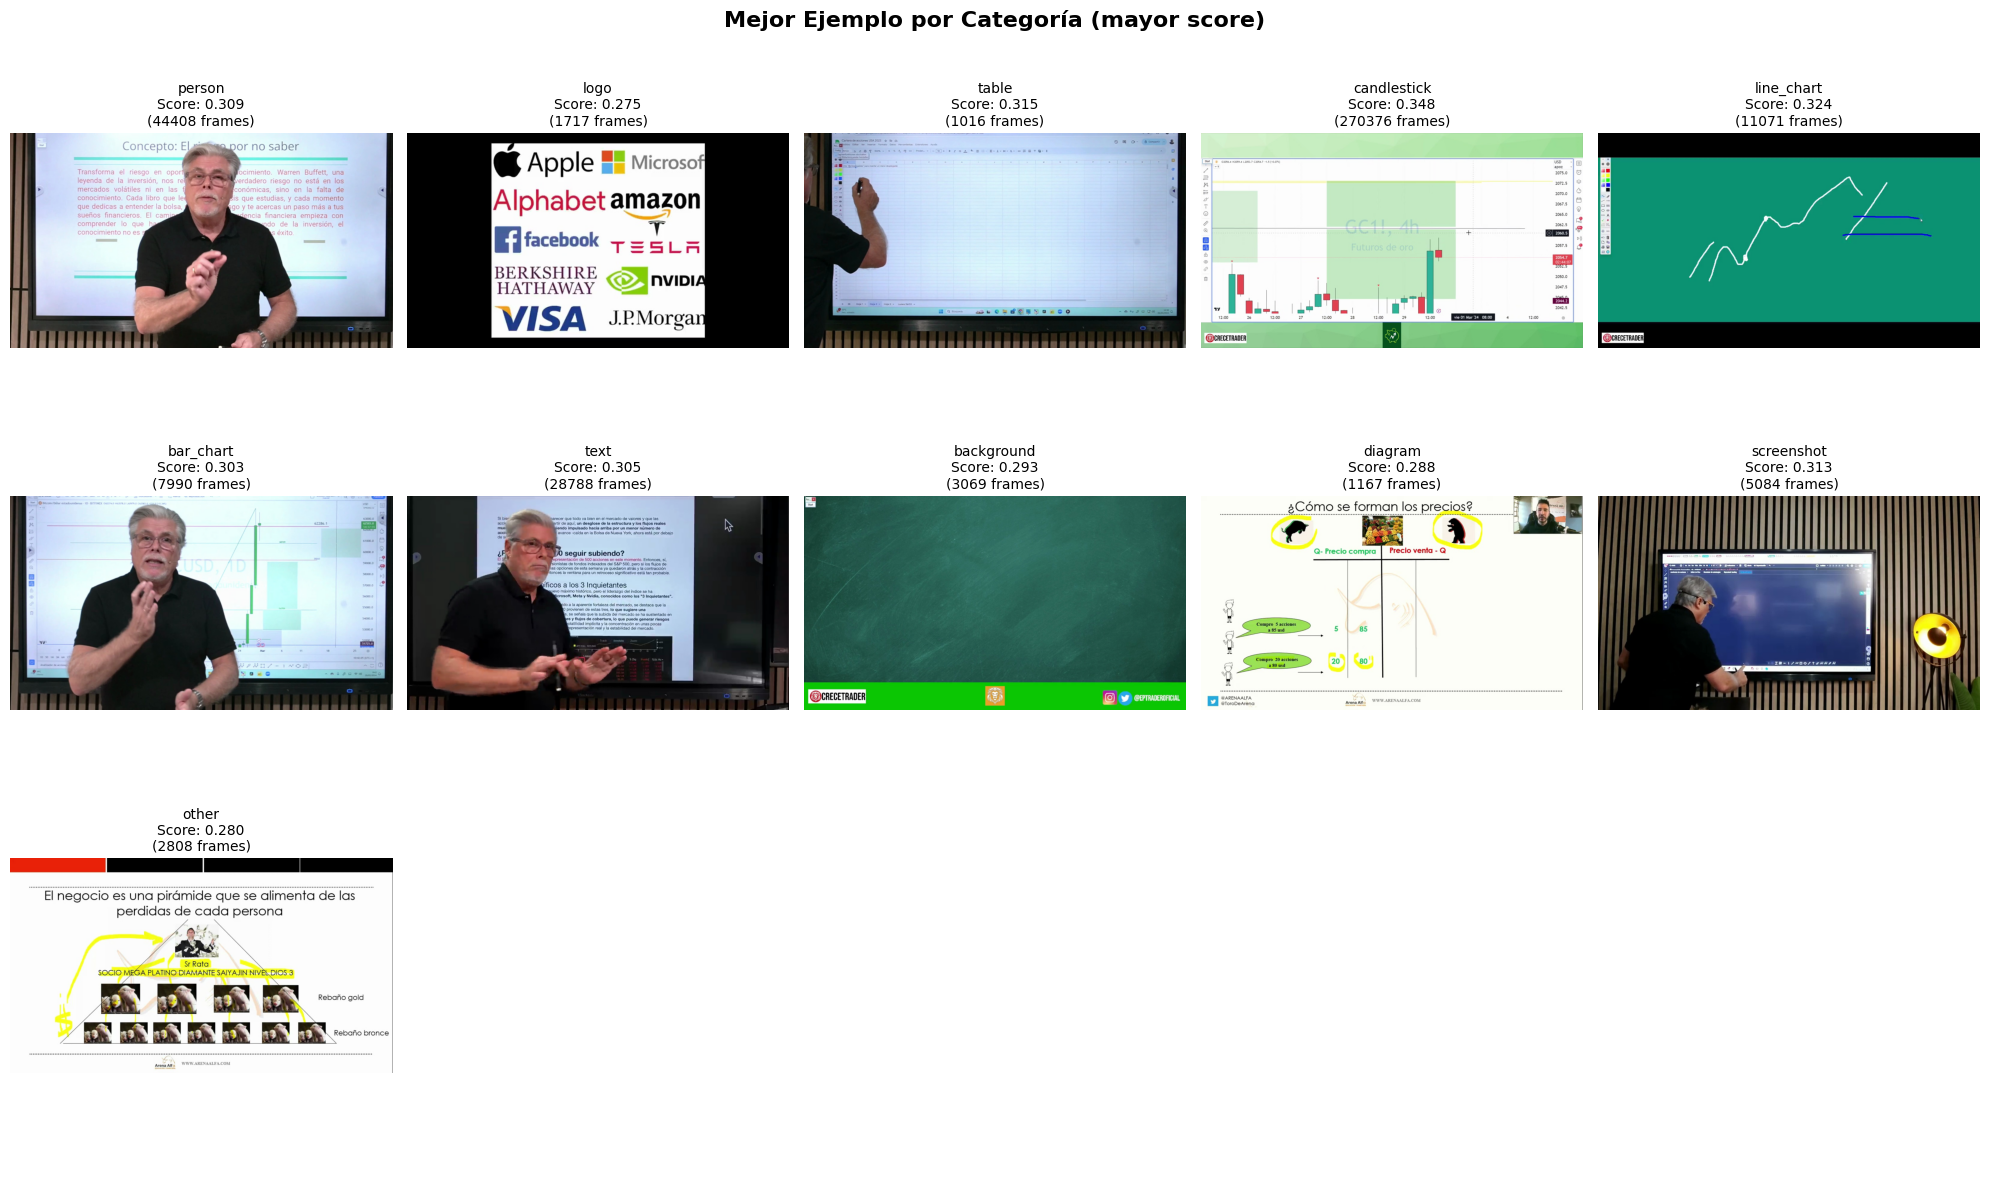

In [75]:
# Mostrar todas las categorías (una muestra por categoría)
print("📊 Vista general de todas las categorías:")
print("=" * 80)

# Configurar grid
n_categories = len(CATEGORY_CODES)
cols = 5
rows = (n_categories + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for cat_idx, category_code in enumerate(CATEGORY_CODES):
    row_idx = cat_idx // cols
    col_idx = cat_idx % cols
    
    category_frames = df_frames[df_frames['clip_category_code'] == category_code]
    
    if len(category_frames) == 0:
        axes[row_idx, col_idx].text(0.5, 0.5, f'{category_code}\nSin ejemplos', 
                                    ha='center', va='center', fontsize=12)
        axes[row_idx, col_idx].axis('off')
        continue
    
    # Tomar el mejor ejemplo (mayor score)
    best_frame = category_frames.nlargest(1, 'clip_score').iloc[0]
    
    try:
        image = Image.open(best_frame['frame_path'])
        axes[row_idx, col_idx].imshow(image)
        title = f"{category_code}\nScore: {best_frame['clip_score']:.3f}\n({len(category_frames)} frames)"
        axes[row_idx, col_idx].set_title(title, fontsize=10)
        axes[row_idx, col_idx].axis('off')
    except Exception as e:
        axes[row_idx, col_idx].text(0.5, 0.5, f'{category_code}\nError', 
                                    ha='center', va='center', fontsize=10)
        axes[row_idx, col_idx].axis('off')

# Ocultar ejes vacíos
for i in range(n_categories, rows * cols):
    row_idx = i // cols
    col_idx = i % cols
    axes[row_idx, col_idx].axis('off')

plt.suptitle('Mejor Ejemplo por Categoría (mayor score)', fontsize=16, fontweight='bold')
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/clip_category_examples_overview.png", dpi=300, bbox_inches='tight')
print(f"📊 Vista general guardada en images/clip_category_examples_overview.png")
plt.show()


### Análisis de Confianza y Casos Ambiguos


⚠️  Frames con baja confianza (score < 0.18):
   Total: 28 (0.01%)

📊 Distribución por categoría:
   background     :      9 frames
   text           :      7 frames
   logo           :      5 frames
   candlestick    :      2 frames
   line_chart     :      2 frames
   other          :      2 frames
   diagram        :      1 frames

🖼️  Ejemplos de frames con baja confianza:
📊 Ejemplos guardados en images/clip_low_confidence_examples.png


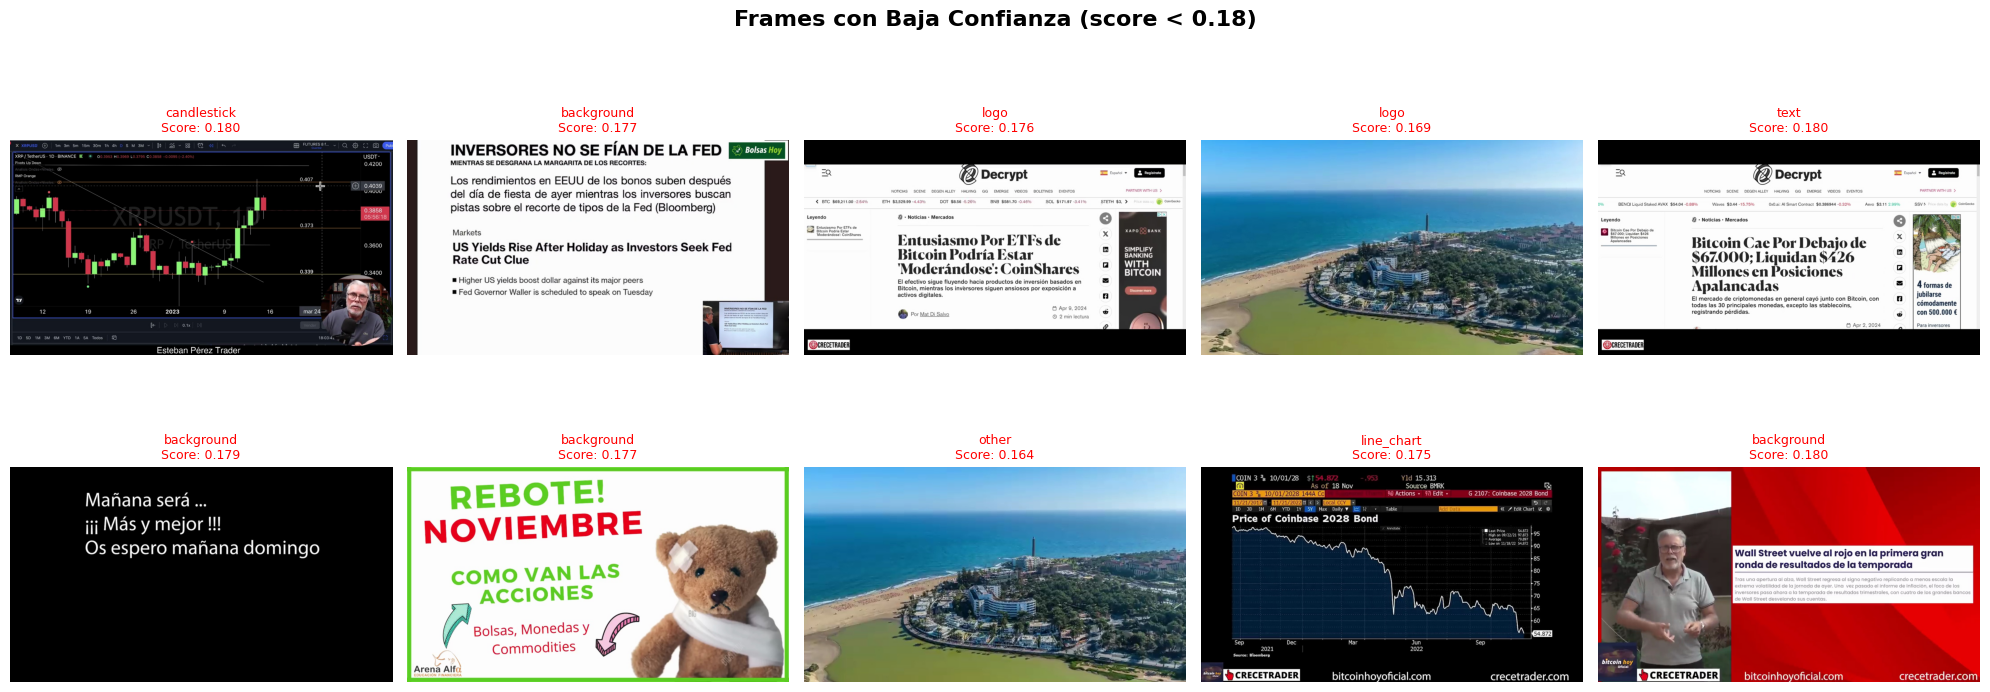

In [81]:
# Analizar frames con baja confianza (posibles errores)
THRESHOLD_LOW_CONFIDENCE = 0.18 #0.20  # Score mínimo para considerar confiable

low_confidence_frames = df_frames[df_frames['clip_score'] < THRESHOLD_LOW_CONFIDENCE]

print(f"⚠️  Frames con baja confianza (score < {THRESHOLD_LOW_CONFIDENCE}):")
print(f"   Total: {len(low_confidence_frames):,} ({len(low_confidence_frames)/len(df_frames)*100:.2f}%)")
print(f"\n📊 Distribución por categoría:")
low_conf_by_category = low_confidence_frames['clip_category_code'].value_counts()
for cat, count in low_conf_by_category.items():
    print(f"   {cat:15s}: {count:6,} frames")

# Mostrar algunos ejemplos de baja confianza
if len(low_confidence_frames) > 0:
    print(f"\n🖼️  Ejemplos de frames con baja confianza:")
    sample_low = low_confidence_frames.sample(min(10, len(low_confidence_frames)), random_state=42)
    
    cols = 5
    rows = (len(sample_low) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (idx, row) in enumerate(sample_low.iterrows()):
        row_idx = i // cols
        col_idx = i % cols
        
        try:
            image = Image.open(row['frame_path'])
            axes[row_idx, col_idx].imshow(image)
            title = f"{row['clip_category_code']}\nScore: {row['clip_score']:.3f}"
            axes[row_idx, col_idx].set_title(title, fontsize=9, color='red')
            axes[row_idx, col_idx].axis('off')
        except Exception as e:
            axes[row_idx, col_idx].text(0.5, 0.5, f'Error', ha='center', va='center', fontsize=8)
            axes[row_idx, col_idx].axis('off')
    
    # Ocultar ejes vacíos
    for i in range(len(sample_low), rows * cols):
        row_idx = i // cols
        col_idx = i % cols
        axes[row_idx, col_idx].axis('off')
    
    plt.suptitle(f'Frames con Baja Confianza (score < {THRESHOLD_LOW_CONFIDENCE})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig("images/clip_low_confidence_examples.png", dpi=300, bbox_inches='tight')
    print(f"📊 Ejemplos guardados en images/clip_low_confidence_examples.png")
    plt.show()


### Estadísticas de Calidad por Categoría

Analiza la calidad del etiquetado por categoría para identificar qué categorías funcionan mejor.


📊 ESTADÍSTICAS DE CALIDAD POR CATEGORÍA:
   category  count  percentage  mean_score  median_score  min_score  max_score  std_score  low_confidence_count  low_confidence_pct
candlestick 270376   71.623920    0.262575      0.262525   0.174181   0.347959   0.017791                   121            0.044752
  bar_chart   7990    2.116590    0.256402      0.258989   0.180789   0.302896   0.017515                    16            0.200250
      table   1016    0.269143    0.255403      0.257379   0.184368   0.315100   0.024957                    13            1.279528
 line_chart  11071    2.932762    0.252401      0.252298   0.174570   0.323528   0.018827                    23            0.207750
 screenshot   5084    1.346776    0.249579      0.248776   0.181112   0.313350   0.016068                     6            0.118017
       text  28788    7.626081    0.245387      0.245834   0.175327   0.304786   0.017324                   213            0.739892
     person  44408   11.763896    0

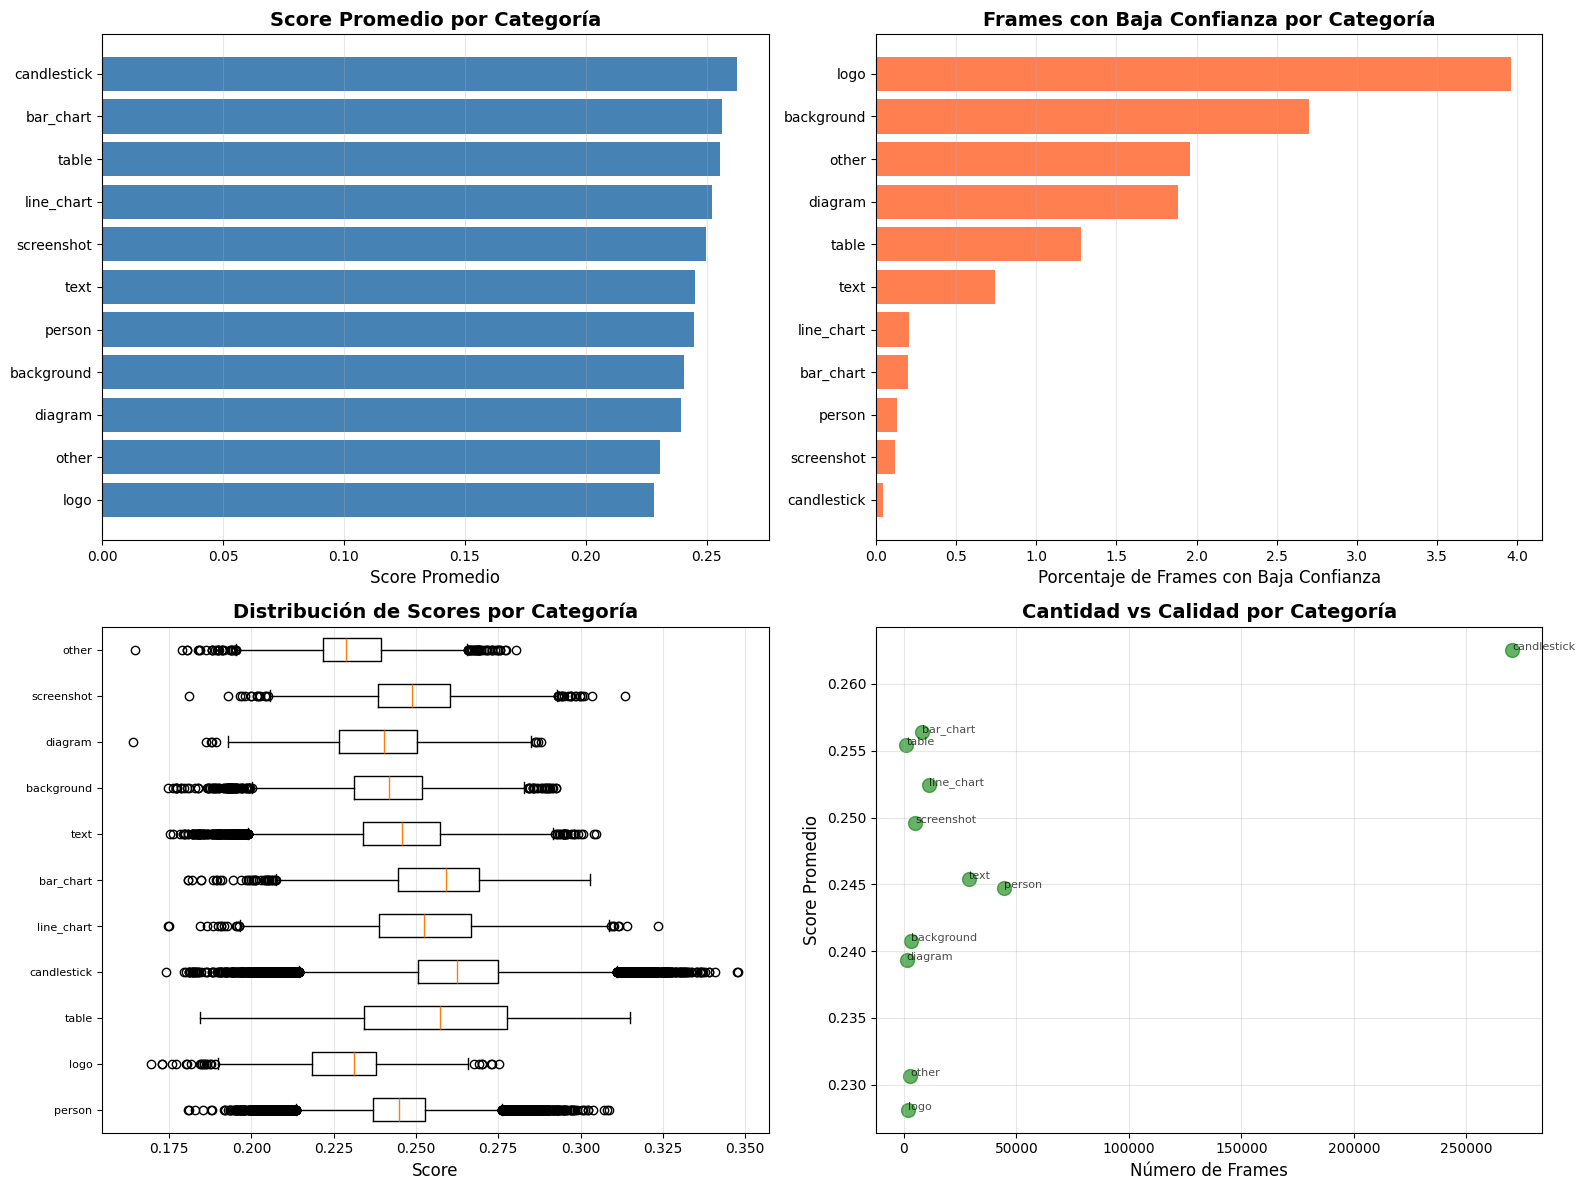

💾 Estadísticas de calidad guardadas en datasets/clip_quality_stats.csv


In [77]:
# Calcular estadísticas de calidad por categoría
quality_stats = []

for category_code in CATEGORY_CODES:
    cat_frames = df_frames[df_frames['clip_category_code'] == category_code]
    
    if len(cat_frames) == 0:
        continue
    
    quality_stats.append({
        'category': category_code,
        'count': len(cat_frames),
        'percentage': len(cat_frames) / len(df_frames) * 100,
        'mean_score': cat_frames['clip_score'].mean(),
        'median_score': cat_frames['clip_score'].median(),
        'min_score': cat_frames['clip_score'].min(),
        'max_score': cat_frames['clip_score'].max(),
        'std_score': cat_frames['clip_score'].std(),
        'low_confidence_count': len(cat_frames[cat_frames['clip_score'] < THRESHOLD_LOW_CONFIDENCE]),
        'low_confidence_pct': len(cat_frames[cat_frames['clip_score'] < THRESHOLD_LOW_CONFIDENCE]) / len(cat_frames) * 100
    })

quality_df = pd.DataFrame(quality_stats)
quality_df = quality_df.sort_values('mean_score', ascending=False)

print("📊 ESTADÍSTICAS DE CALIDAD POR CATEGORÍA:")
print("=" * 100)
print(quality_df.to_string(index=False))

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Score promedio por categoría
ax1 = axes[0, 0]
quality_df_sorted = quality_df.sort_values('mean_score', ascending=True)
ax1.barh(quality_df_sorted['category'], quality_df_sorted['mean_score'], color='steelblue')
ax1.set_xlabel('Score Promedio', fontsize=12)
ax1.set_title('Score Promedio por Categoría', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Porcentaje de frames con baja confianza
ax2 = axes[0, 1]
quality_df_sorted_low = quality_df.sort_values('low_confidence_pct', ascending=True)
ax2.barh(quality_df_sorted_low['category'], quality_df_sorted_low['low_confidence_pct'], color='coral')
ax2.set_xlabel('Porcentaje de Frames con Baja Confianza', fontsize=12)
ax2.set_title('Frames con Baja Confianza por Categoría', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Distribución de scores por categoría (boxplot)
ax3 = axes[1, 0]
score_data = []
labels = []
for category_code in CATEGORY_CODES:
    cat_scores = df_frames[df_frames['clip_category_code'] == category_code]['clip_score']
    if len(cat_scores) > 0:
        score_data.append(cat_scores)
        labels.append(category_code)
ax3.boxplot(score_data, labels=labels, vert=False)
ax3.set_xlabel('Score', fontsize=12)
ax3.set_title('Distribución de Scores por Categoría', fontsize=14, fontweight='bold')
ax3.tick_params(axis='y', labelsize=8)
ax3.grid(axis='x', alpha=0.3)

# Count vs Mean Score (scatter)
ax4 = axes[1, 1]
ax4.scatter(quality_df['count'], quality_df['mean_score'], s=100, alpha=0.6, color='green')
for _, row in quality_df.iterrows():
    ax4.annotate(row['category'], (row['count'], row['mean_score']), 
                fontsize=8, alpha=0.7)
ax4.set_xlabel('Número de Frames', fontsize=12)
ax4.set_ylabel('Score Promedio', fontsize=12)
ax4.set_title('Cantidad vs Calidad por Categoría', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("images/clip_quality_analysis.png", dpi=300, bbox_inches='tight')
print(f"\n📊 Análisis de calidad guardado en images/clip_quality_analysis.png")
plt.show()

# Guardar estadísticas
quality_df.to_csv("datasets/clip_quality_stats.csv", index=False)
print(f"💾 Estadísticas de calidad guardadas en datasets/clip_quality_stats.csv")


### Recomendaciones para Ajustar Categorías

Basado en el análisis, puedes ajustar las categorías para mejorar el etiquetado.


In [79]:
# Recomendaciones automáticas basadas en el análisis
print("💡 RECOMENDACIONES PARA AJUSTAR CATEGORÍAS:")
print("=" * 80)

# Categorías con baja confianza
low_confidence_categories = quality_df[quality_df['low_confidence_pct'] > 30]
if len(low_confidence_categories) > 0:
    print(f"\n⚠️  Categorías con >30% de frames con baja confianza:")
    for _, row in low_confidence_categories.iterrows():
        print(f"   - {row['category']}: {row['low_confidence_pct']:.1f}% baja confianza")
        print(f"     Considera: Refinar la descripción de la categoría en inglés")
        print(f"     Ejemplo: '{CATEGORIES[CATEGORY_CODES.index(row['category'])]}'")

# Categorías con muy pocos frames
low_count_categories = quality_df[quality_df['count'] < len(df_frames) * 0.01]  # < 1%
if len(low_count_categories) > 0:
    print(f"\n📊 Categorías con muy pocos frames (<1%):")
    for _, row in low_count_categories.iterrows():
        print(f"   - {row['category']}: {row['count']} frames ({row['percentage']:.2f}%)")
        print(f"     Considera: Combinar con categoría similar o eliminar si no es relevante")

# Categorías con alta confianza
high_confidence_categories = quality_df[quality_df['mean_score'] > 0.30]
if len(high_confidence_categories) > 0:
    print(f"\n✅ Categorías con alta confianza (score > 0.30):")
    for _, row in high_confidence_categories.iterrows():
        print(f"   - {row['category']}: Score promedio {row['mean_score']:.3f}")
        print(f"     Estas categorías funcionan bien, no necesitan ajustes")



💡 RECOMENDACIONES PARA AJUSTAR CATEGORÍAS:

📊 Categorías con muy pocos frames (<1%):
   - table: 1016 frames (0.27%)
     Considera: Combinar con categoría similar o eliminar si no es relevante
   - background: 3069 frames (0.81%)
     Considera: Combinar con categoría similar o eliminar si no es relevante
   - diagram: 1167 frames (0.31%)
     Considera: Combinar con categoría similar o eliminar si no es relevante
   - other: 2808 frames (0.74%)
     Considera: Combinar con categoría similar o eliminar si no es relevante
   - logo: 1717 frames (0.45%)
     Considera: Combinar con categoría similar o eliminar si no es relevante
